In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.image as mpim
import matplotlib.animation as animation

#open files
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

#grab the "protons on target" measurement for each dataset
pot = file["totpot"].member("fElements")[0] 
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

#unpack each file and grab the relevant variables
Numu_cc = file["tree_numu_cc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Numu_nc = file["tree_numu_nc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
Numu_cc["pot_weight"] = Numu_cc["weight"] * (des_pot / pot)
Numu_nc["pot_weight"] = Numu_nc["weight"] * (des_pot / pot)
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)


#split datasets into neutrino types
cc_mu = Numu_cc[(Numu_cc["nu_pdg"] == 14.0)]
cc_mua = Numu_cc[(Numu_cc["nu_pdg"] == -14.0)]
nc_mu = Numu_nc[(Numu_nc["nu_pdg"] == 14.0)]
nc_mua = Numu_nc[(Numu_nc["nu_pdg"] == -14.0)]
osc_e = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ea = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == -12.0)]
intrin_e = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ea = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == -12.0)]

/tmp/ipykernel_664592/4021996482.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


$sin^2(2\theta_{ee}) = sin^2(2\theta_{14})$

$sin^2(2\theta_{\mu\mu}) ~= sin^2(2\theta_{24})$

$sin^2(2\theta_{\mu e}) ~= \frac{1}{4}sin^2(2\theta_{14})sin^2(2\theta_{24})$

In [2]:
# probability for mu->e, e->e, and mu->mu oscillations
# in terms of Ue4, Um4, and deltam2_41
def prob_energy(params, deltam_41, L_E, Paa="mue", sin2s=False):
    if (sin2s==False):
        Ue4, Um4 = params
    
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            probab = ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            probab =  1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            probab = 1 - ((4*(Um4**2)*(1-(Um4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    else:
        sin2_14, sin2_24 = params
        
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            # sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
            probab = (0.25 * sin2_14 * sin2_24) * (np.sin(1.27*deltam_41*L_E))**2
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            # sin2(2*theta_ee) ~= sin2(2*theta_14)
            probab =  1 - ((sin2_14) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            # sin2(2*theta_mumu) ~= sin2(2*theta_24)
            probab = 1 - ((sin2_24) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    return(probab)


In [3]:
# create my covariance matrix:
# the diagonals are cov2_sys_i + sigma2_stat_i
# the off-diagonals are rho_ij*cov_sys_i*cov_sys_j
# we can make 4 seperate matrices: flux, cross-section, detector, and statistical and add them together (basically in quadrature)
# the matrix will be a (N_nue + N_numu) square

flux_sig = 0.15
flux_rho = 0.5

cross_sig = 0.2
cross_rho = 1

detect_sig = 0.03
detect_rho = 0

In [4]:
#if the expected count is 0, the sum goes to infinity, so just skip those boxes for right now
def chi2(expect, obs, error="poisson", dof_normalize=False, subtract_from_dof=0):
    if (np.isin(expect,0).any()):
        print("The expected freqency has a bin with 0 entries")
        return
    
    if (error=="poisson"):
        # uncorrelated data with poisson only error
        # sigma = sqrt(expected)
        # diff^2 / sigma^2
        diff = obs - expect
        diff2 = diff**2
        diff3 = diff2/expect
        
        chi2 =0
        n = 0
        for i in diff3:
            n = n+1
            if (np.isinf(i)):
                continue
            chi2 = chi2 + i

        if(dof_normalize):
            dof = n - subtract_from_dof
            chi2 = chi2/dof
            #print("chi2 per dof (" + str(dof) +"): "+str(chi2))
            return chi2
        else:
            #print("total chi2: " + str(chi2))
            return chi2
        
        
    elif (error=="correlated"):
        #this is for both nue and numu data that has correlated errors
        # assuming that the bins have already been appended together into the expect and obs arrays
        # currently only has non-dof-normalized option
        #print("inside correlated")
        
        stat_cov = np.zeros([expect.shape[0], expect.shape[0]])
        fractional_error = expect/(expect**2)
        np.fill_diagonal(stat_cov, fractional_error)
        # print("expect")
        # print(expect)
        # print("stat_cov")
        # print(stat_cov)
        
        flux_cov = np.zeros([expect.shape[0], expect.shape[0]])
        flux_cov.fill(flux_sig*flux_sig*flux_rho)
        np.fill_diagonal(flux_cov, flux_sig*flux_sig*1)
        # print("flux_cov")
        # print(flux_cov)
        
        cross_cov = np.zeros([expect.shape[0], expect.shape[0]])
        cross_cov.fill(cross_sig*cross_sig*cross_rho)
        np.fill_diagonal(cross_cov, cross_sig*cross_sig*1)
        # print("cross_cov")
        # print(cross_cov)
        
        detect_cov = np.zeros([expect.shape[0], expect.shape[0]])
        detect_cov.fill(detect_sig*detect_sig*detect_rho)
        np.fill_diagonal(detect_cov, detect_sig*detect_sig*1)
        # print("detect_cov")
        # print(detect_cov)
        
        fract_cov = stat_cov + flux_cov + cross_cov + detect_cov
        # print("fract_cov")
        # print(fract_cov)
        
        cov = fract_cov.copy()
        for i in range(expect.shape[0]):
            for j in range(expect.shape[0]):
                cov[i][j] = cov[i][j] * expect[i] * expect[j]
                
        # print("cov")
        # print(cov)
        
        inverse_cov = np.linalg.inv(cov)
        # print("inverse_cov")
        # print(inverse_cov)
        
        chi2 = 0
        for i in range(len(expect)):
            for j in range(len(expect)):
                dif1 = obs[i] - expect[i]
                dif2 = obs[j] - expect[j]
                diff2 = dif1*dif2
                
                diff3 = diff2 * inverse_cov[i][j] #or should it be j,i now that its inversed? 
                chi2 = chi2 + diff3
                # print(i, j)
                # print("obsi", obs[i], "expecti", expect[i])
                # print("obsj", obs[j], "expectj", expect[j])
                # print("diffs", dif1, dif2, diff2)
                # print("covariance element", inverse_cov[i][j])
                # print("chi2 element", diff3)
                # print("total chi2", chi2)
            
        return (chi2)


In [5]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intrinisc_nue_mc and fullosc_mc AND unosc_intrinsic_numu_mc
def osc_chi2(params, unosc_intrinsic_nue_mc, fullosc_mc,unosc_intrinsic_numu_mc, n=1, sin2s=False):
    if sin2s==False:
        deltam2, Ue4, Um4 = params
        nue_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee")
        nue_appearance_probs = prob_energy([Ue4, Um4], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu")
        
    else:
        deltam2, sin2_14, sin2_24= params
        nue_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee", sin2s=True)
        nue_appearance_probs = prob_energy([sin2_14, sin2_24], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
        numu_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_numu_mc["true_baseline"]/1000)/unosc_intrinsic_numu_mc["true_energy"], Paa="mumu", sin2s=True)
        
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    numu_survival_weight = unosc_intrinsic_numu_mc["pot_weight"] * numu_survival_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    #now try adding the numu histogram
    numu_intrinsic = np.histogram(unosc_intrinsic_numu_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_numu_mc["pot_weight"]) #total intrinsic numu
    numu_survival = np.histogram(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], weights=numu_survival_weight) #intrinsic numu with oscillation disappearance
    
    #appending together nue and numu
    intrinsic_nu = np.concatenate([nue_intrinsic[0], numu_intrinsic[0]])
    signal_nu = np.concatenate([nue_survival[0]+nue_appearance[0], numu_survival[0]])
    
    nue_chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
    numu_chi2_val = chi2(numu_intrinsic[0], numu_survival[0], dof_normalize=False, subtract_from_dof=3, error="correlated")
    total_chi2_val = chi2(intrinsic_nu, signal_nu, dof_normalize=False, subtract_from_dof=3, error="correlated")
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
        
    plt.figure(figsize=(20,3))
    plt.subplot(131)
    plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
    plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
    plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)) + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
    else:
        plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24) + "\n$\\chi^2=$" + str(round(nue_chi2_val,5)))
#     plt.show()
    
    
    plt.subplot(132)
    plt.hist(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], histtype="step", weights = numu_survival_weight, label="Intrinsic Numu Survival")
    plt.hist(unosc_intrinsic_numu_mc["true_energy"], bins=nue_intrinsic[1], histtype="step", weights= unosc_intrinsic_numu_mc["pot_weight"], label="Unoscillated Intrinsic Numu")
    plt.errorbar(bin_centers,numu_intrinsic[0], yerr=np.sqrt(numu_intrinsic[0]), fmt=" ", color="red", capsize=5)
    plt.errorbar(bin_centers, numu_survival[0], yerr= np.sqrt(numu_survival[0]), fmt=" ", color="black", capsize=5)
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Energy {GeV}")
    if (sin2s==False):
        plt.title("Intrinsic and Oscillated $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)) + "\n$\\chi^2=$" + str(round(numu_chi2_val,5)))
    else:
        plt.title("Intrinsic and Oscillated $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24) + "\n$\\chi^2=$" + str(round(numu_chi2_val,5)))
#    plt.show()
    
    plt.subplot(133)
    plt.plot(intrinsic_nu, label="intrinsic")
    plt.plot(signal_nu, label="signal")
    plt.yscale("log")
    plt.legend()
    plt.ylabel("Events")
    plt.xlabel("Nue then Numu Energies")
    if (sin2s==False):
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $U_{e4}^2=$" + str(Ue4**2) + " and $U_{\\mu4}^2=$" + str(round(Um4**2, 4)) + "\n$\\chi^2=$" + str(round(total_chi2_val,5)))
    else:
        plt.title("Intrinsic and Oscillated $\\nu_e$ and $\\nu_\mu$ \n$\Delta{m}^2_{41}=$" + str(deltam2) + " and $sin^2(2\\theta_{14})=$" + str(sin2_14) + " and $sin^2(2\\theta_{24})=$" + str(sin2_24) + "\n$\\chi^2=$" + str(round(total_chi2_val,5)))
    # plt.show()
    
    return (nue_chi2_val, numu_chi2_val, total_chi2_val)



In [6]:
# FROM: https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1116-PUB.pdf
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
# sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2

# FROM: https://arxiv.org/pdf/1609.07803
# sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
# sin2(2*theta_ee) ~= sin2(2*theta_14)
# sin2(2*theta_mumu) ~= sin2(2*theta_24)

#best fit parameters from IceCube:
# deltm2_41 = 4.5 eV2
# sin2(2*theta_24) = 0.1

#best fit parameters from PROSPECT:
# deltm2_41 = 0.5 eV2
# sin2(2*theta_14) = 0.35

In [7]:
#testing the approximation given above
theta14 = np.arcsin(np.sqrt(0.35))/2
theta24 = np.arcsin(np.sqrt(0.1))/2

a1 = 0.25*0.35*0.1
b1 = 0.35
c1 = 0.1

a2 = 0.25*np.sin(theta24)**2
b2 = 0.35
c2 = 4*np.cos(theta14)**2 * np.sin(theta24)**2 * (1 - np.cos(theta14)**2 * np.sin(theta24)**2)

print(a1, a2)
print(b1, b2)
print(c1, c2)

0.008749999999999999 0.006414587743685774
0.35 0.35
0.1 0.09054171158265283


if sin2(2*theta_14) = 0.35 and 

sin2(2*theta_14) ~= sin2(2*theta_ee) = 4(1-Ue4^2)(Ue4^2)

then... I'm not sure how to find Ue4 or Um4

(30.184134760096573, 0.7834622836998619, 47.51440077980816)
(2.1490231329007923, 0.14190991053972604, 3.244352483633362)


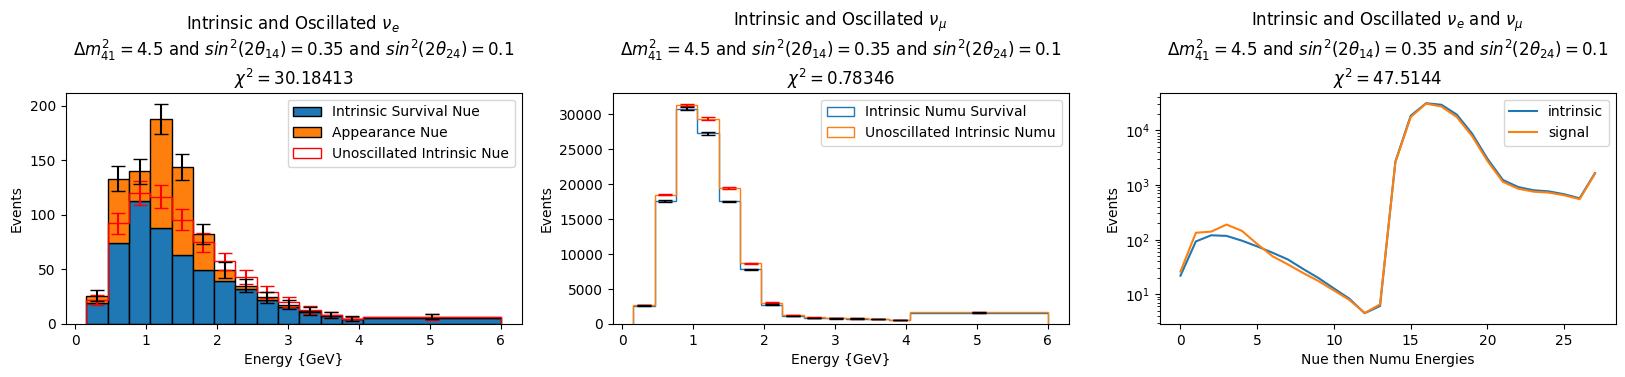

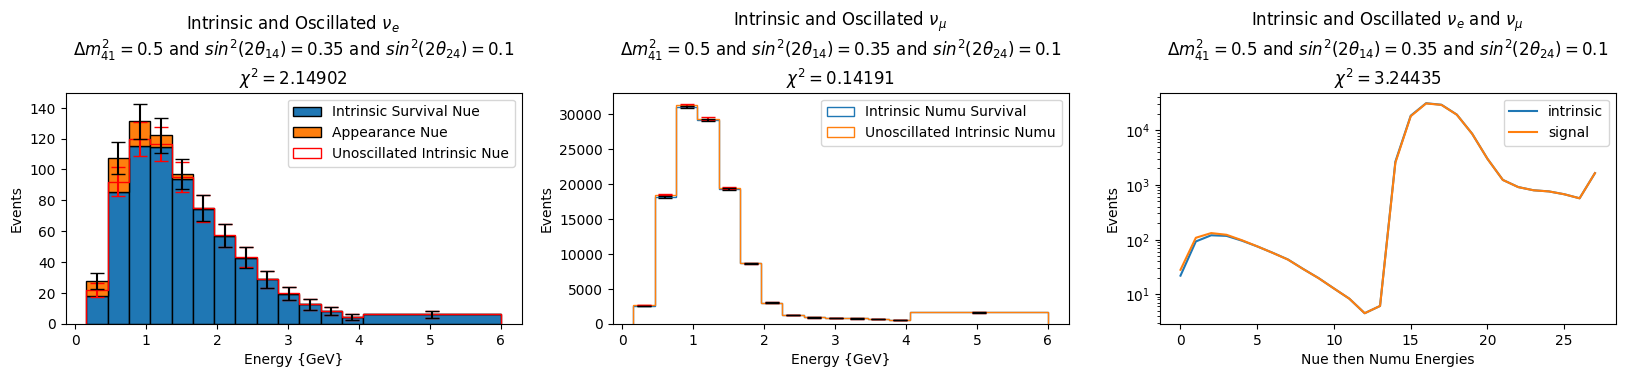

In [8]:
icecube_bestfit = osc_chi2([4.5,0.35,0.1], intrin_e, osc_e, cc_mu, sin2s=True)
prospect_bestfit = osc_chi2([0.5,0.35,0.1], intrin_e, osc_e, cc_mu, sin2s=True)

print(icecube_bestfit)
print(prospect_bestfit)

In [9]:
# figure out what

In [10]:
sin2s_24 = np.logspace(np.log10(1e-5),np.log10(0.2),30, base=10)
sin2s_24_new = np.zeros(31)
sin2s_24_new[0:27] = sin2s_24[0:27]
sin2s_24_new[27] = 0.1
sin2s_24_new[28:31] = sin2s_24[27:30]
sin2s_24 = sin2s_24_new

sin2s_24 = np.arange(0,0.21,0.025)

sin2s_14 = np.arange(0,0.51,0.05)

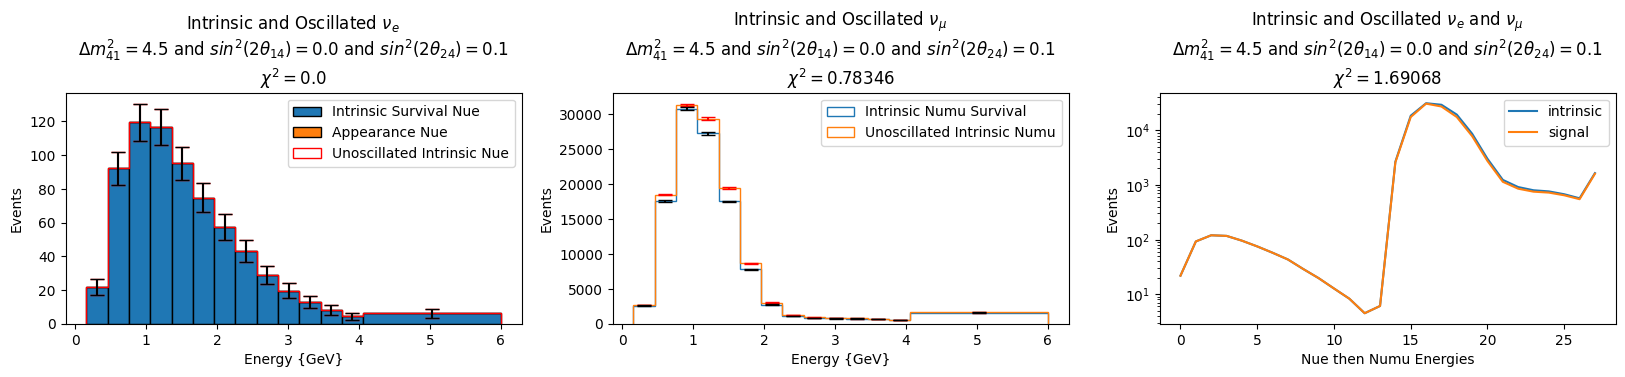

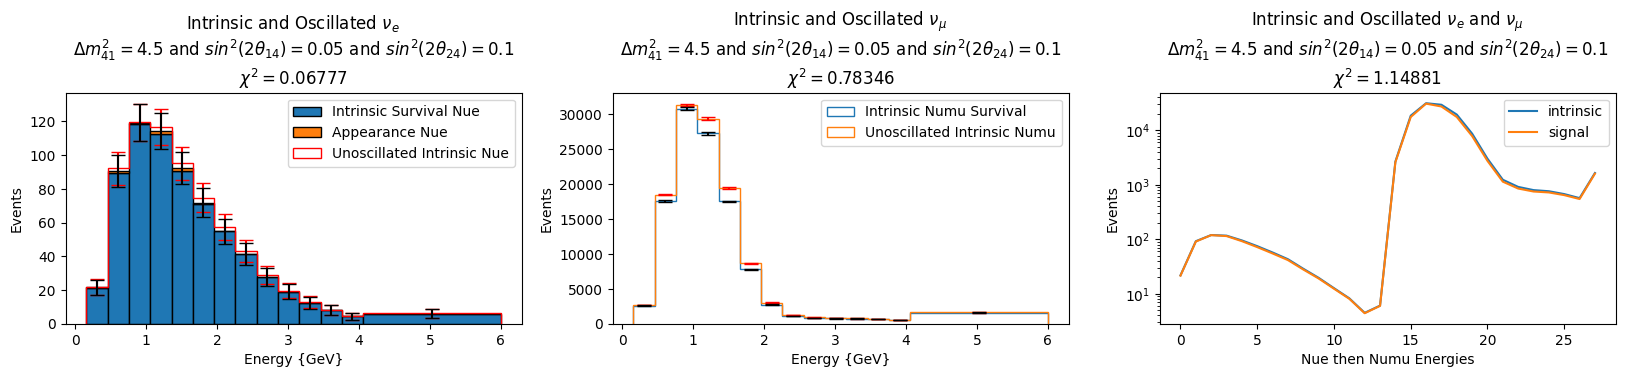

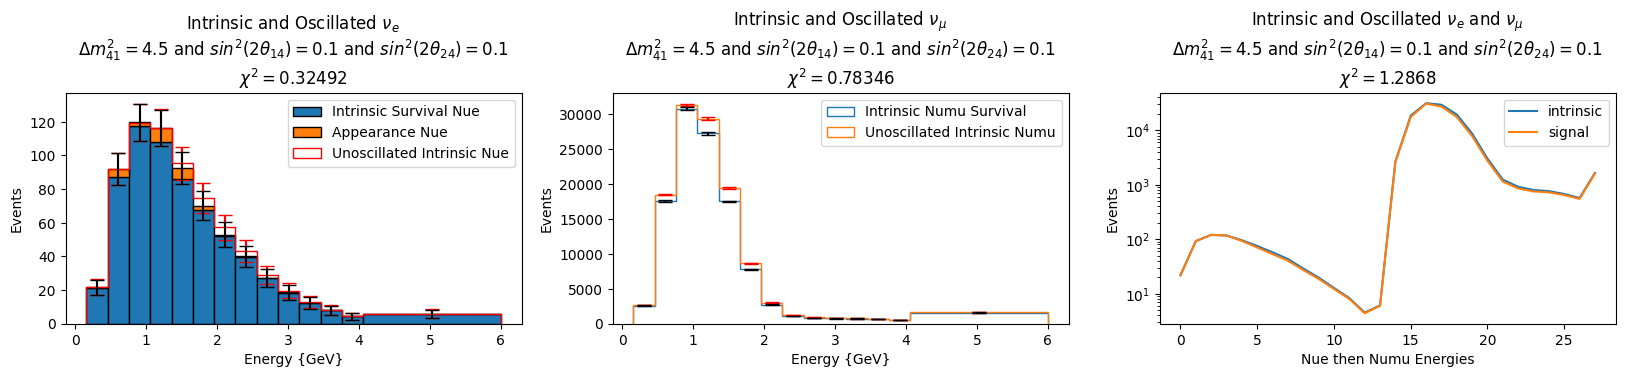

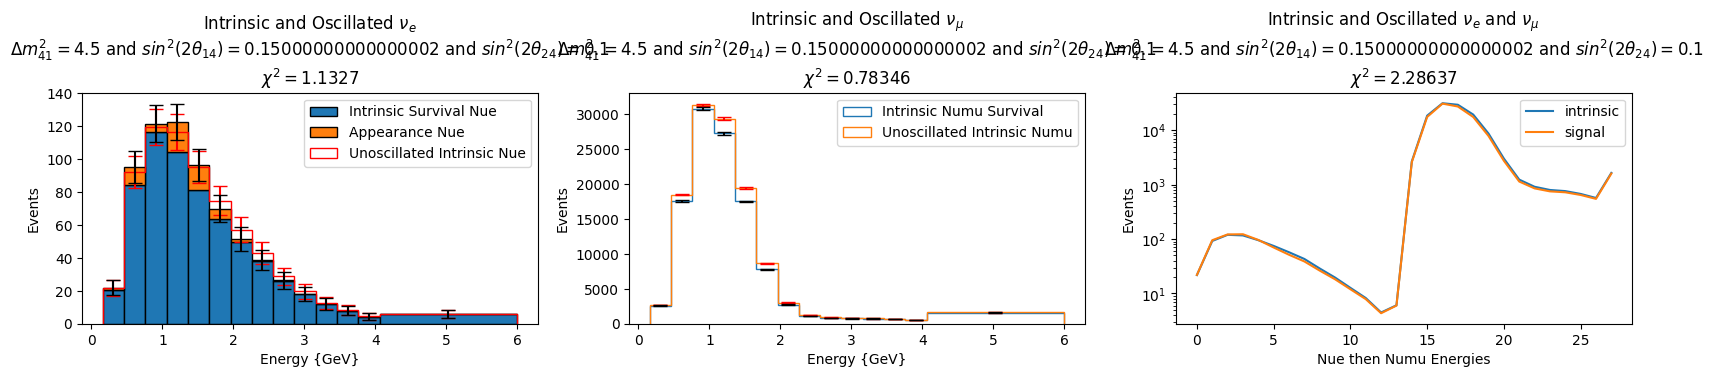

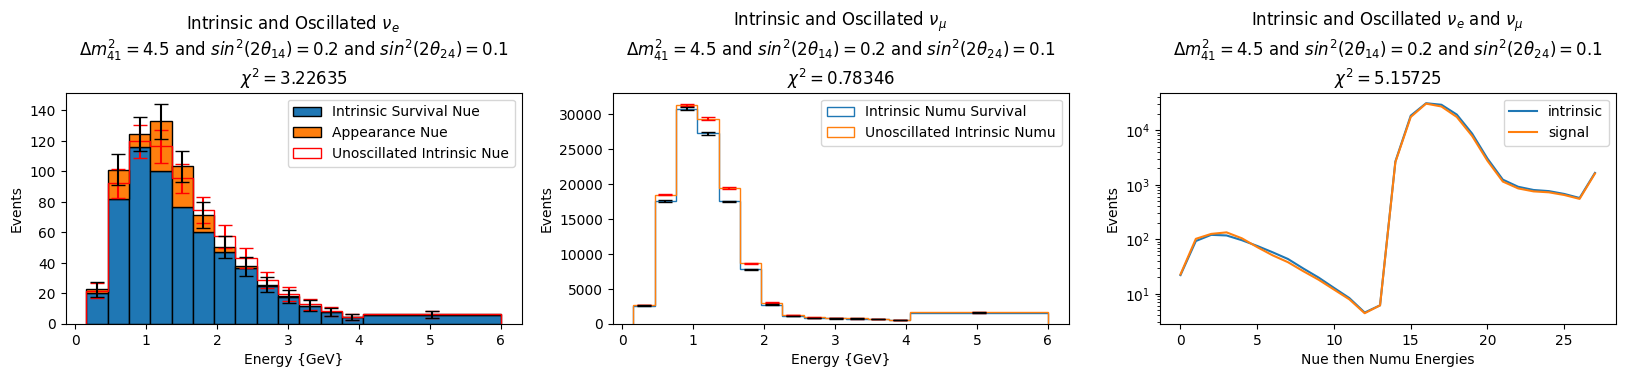

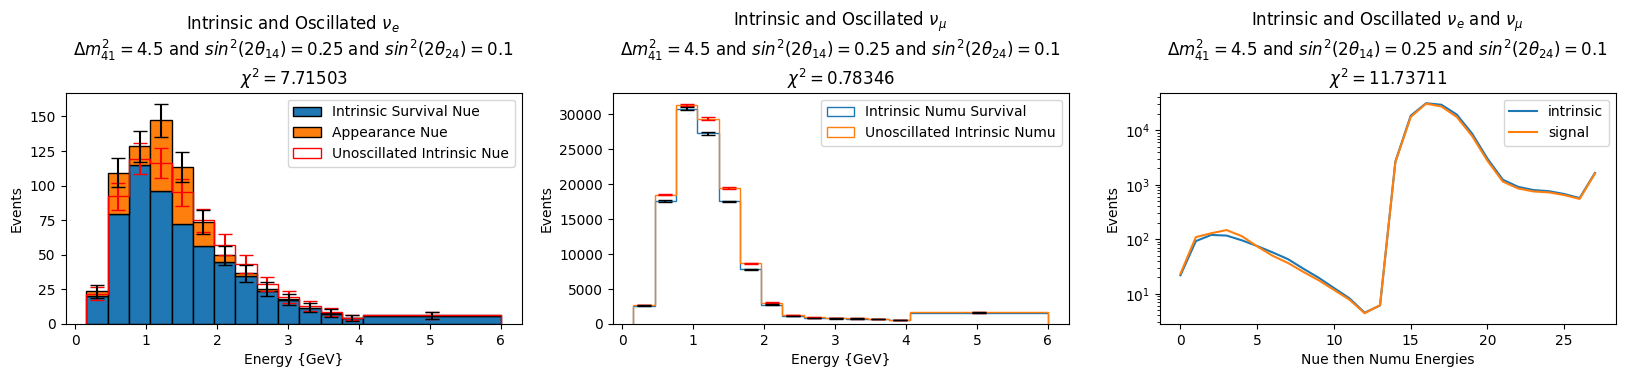

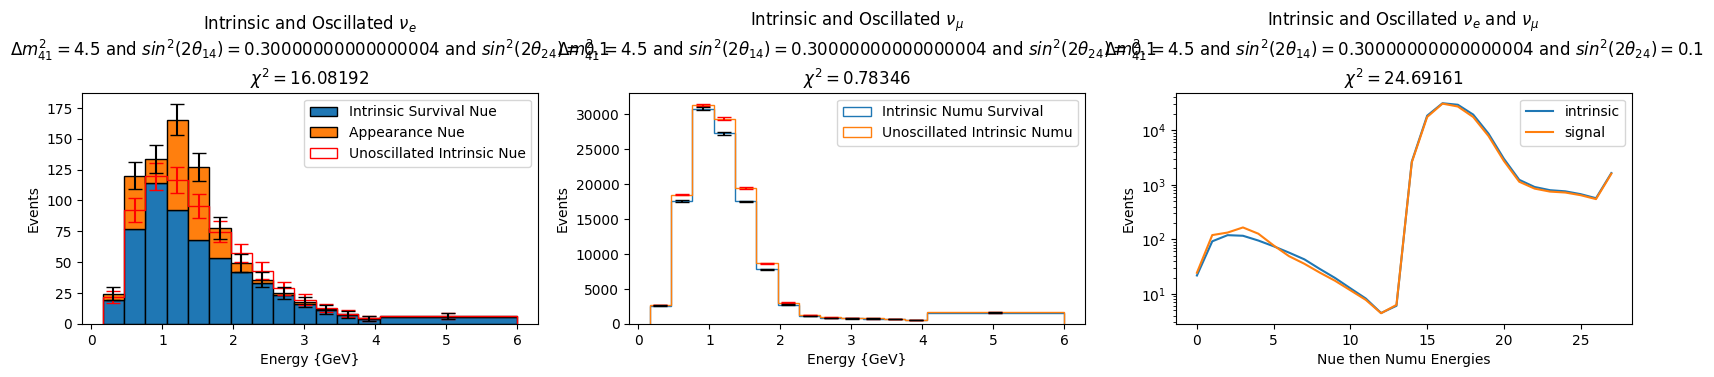

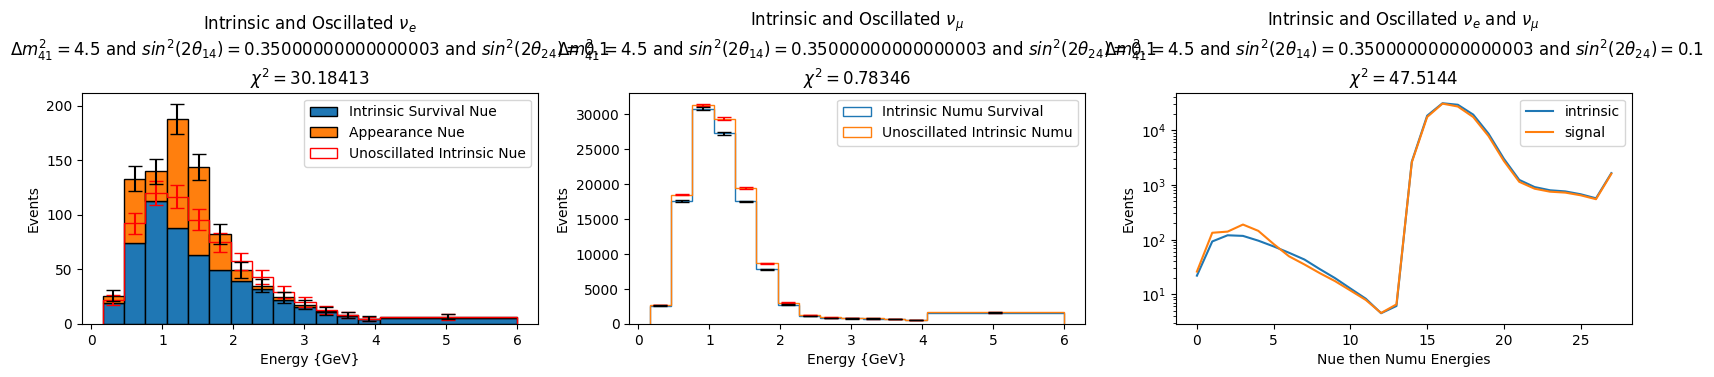

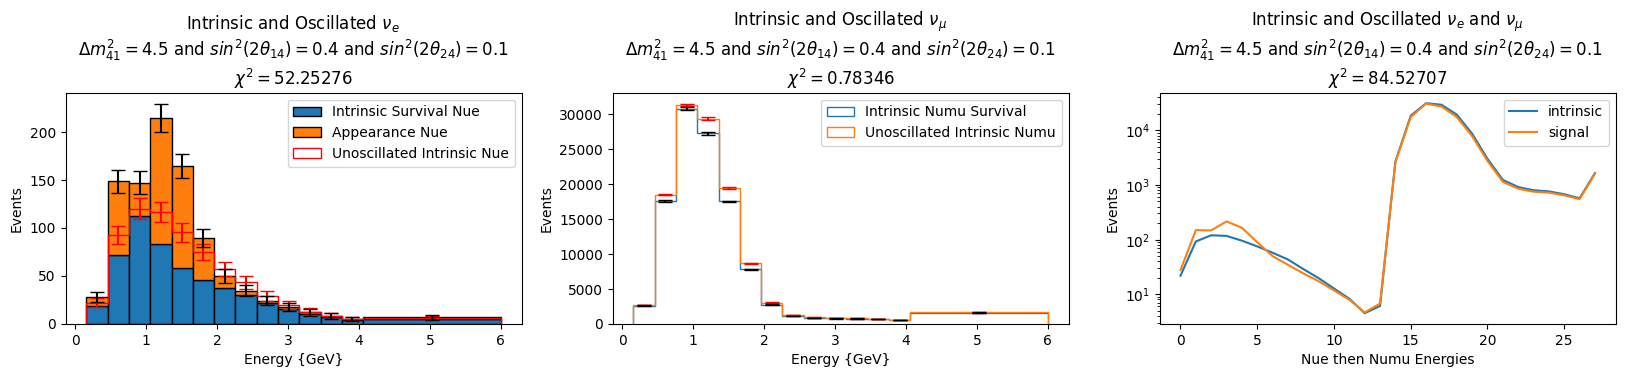

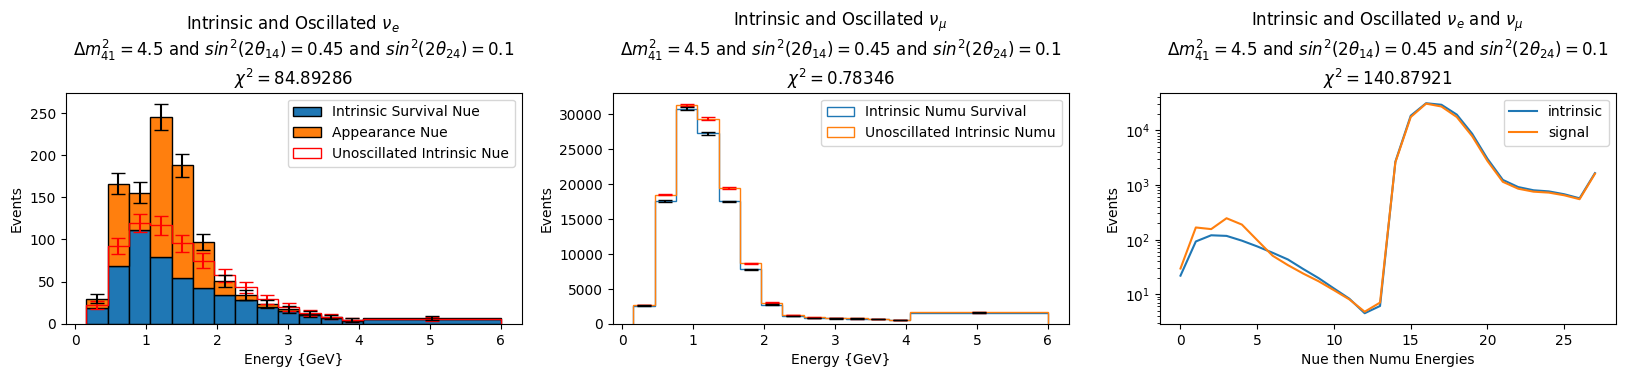

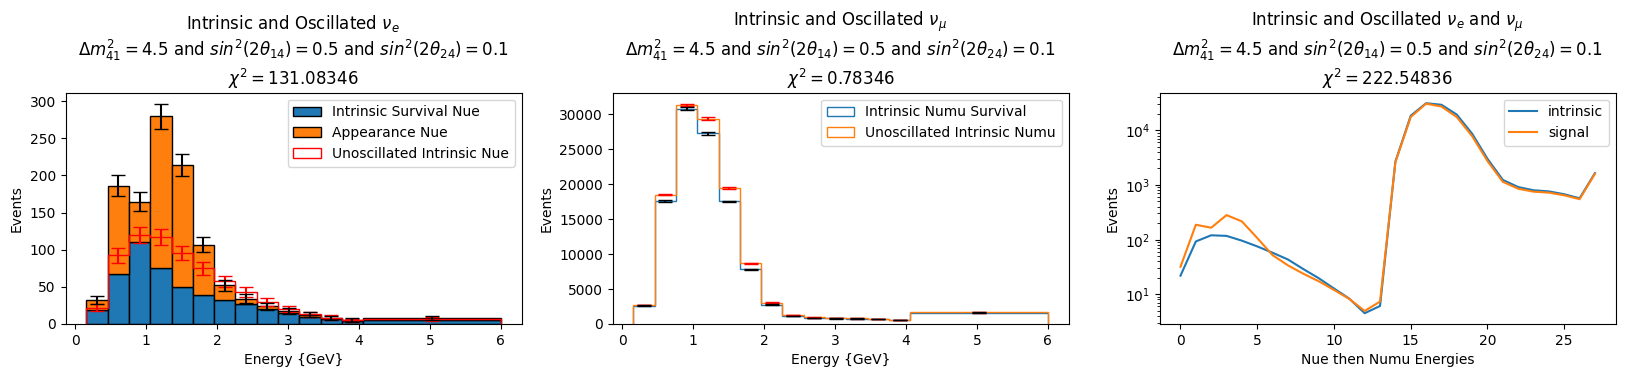

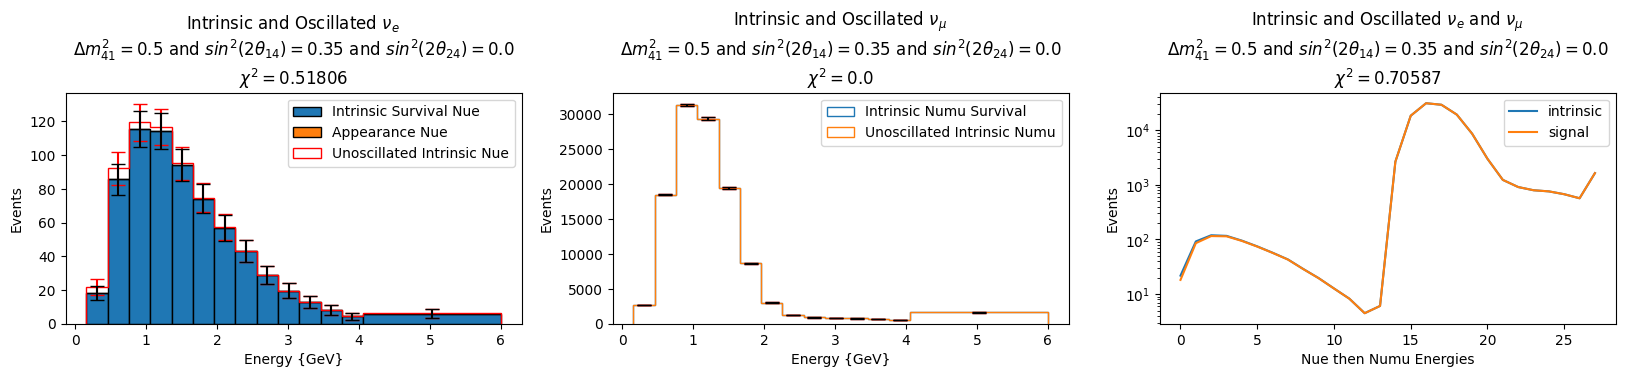

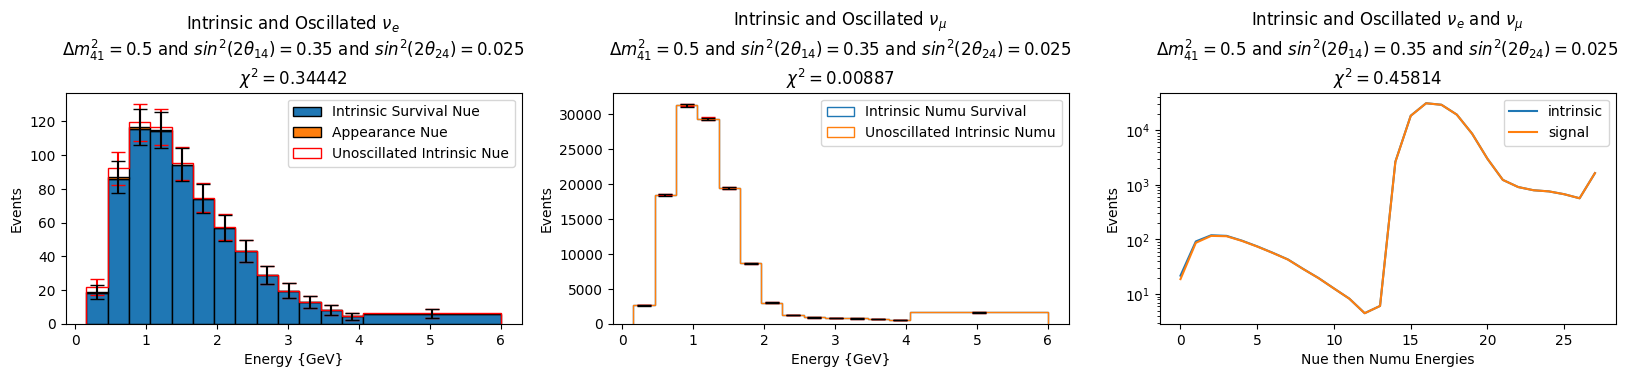

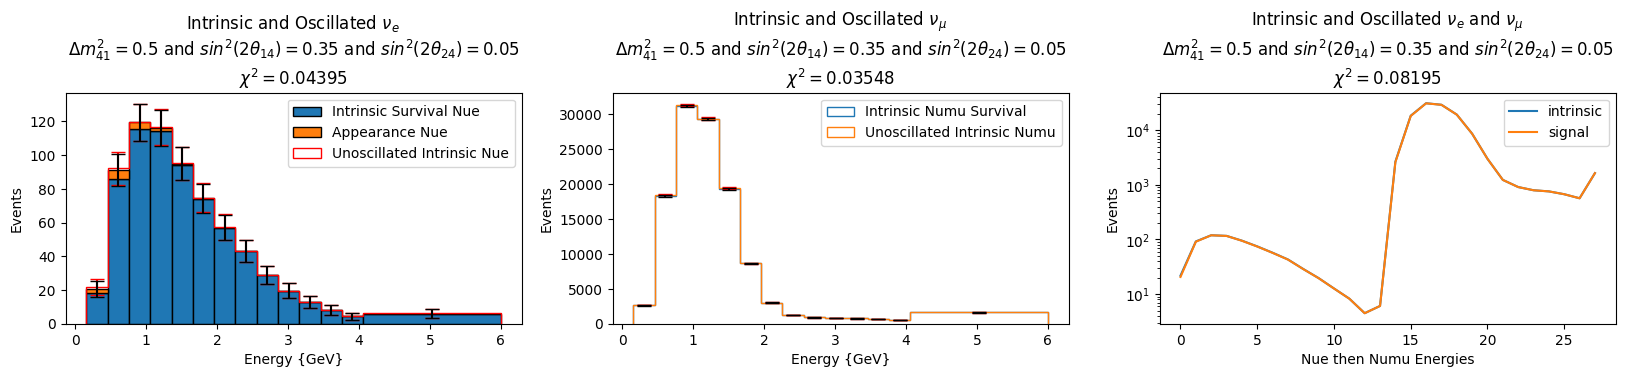

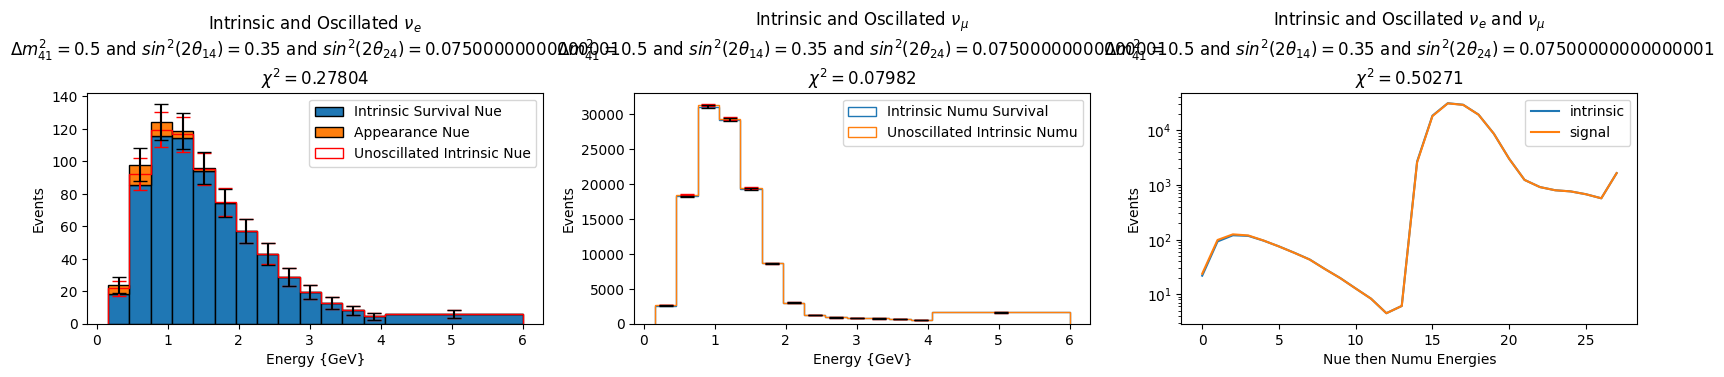

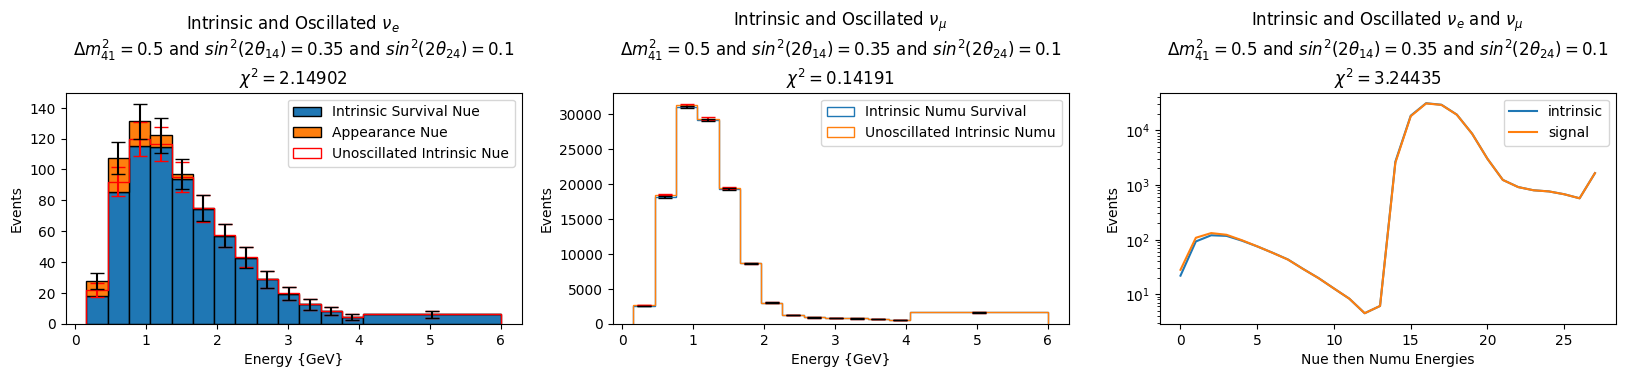

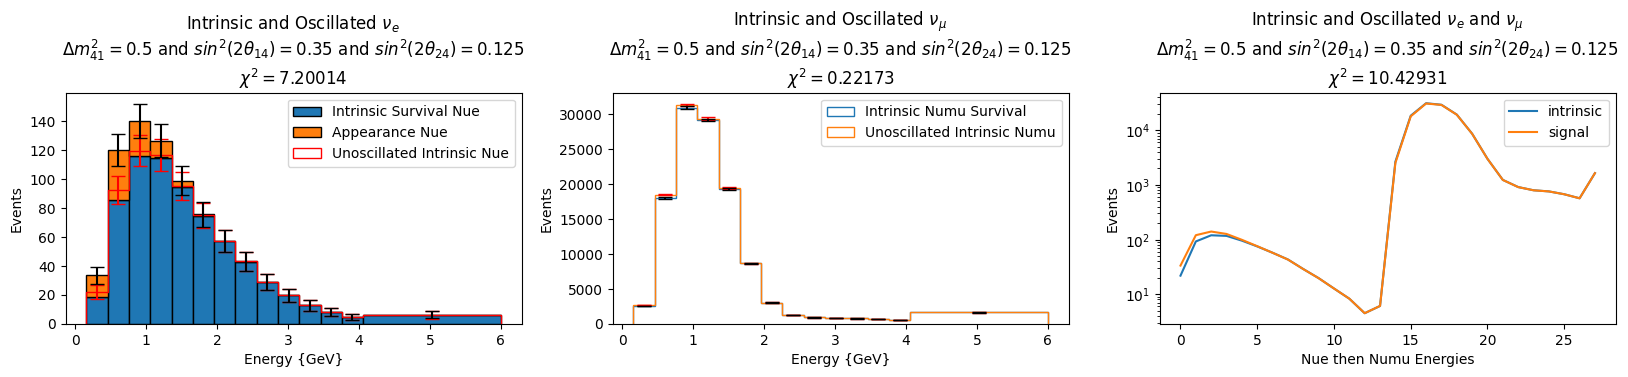

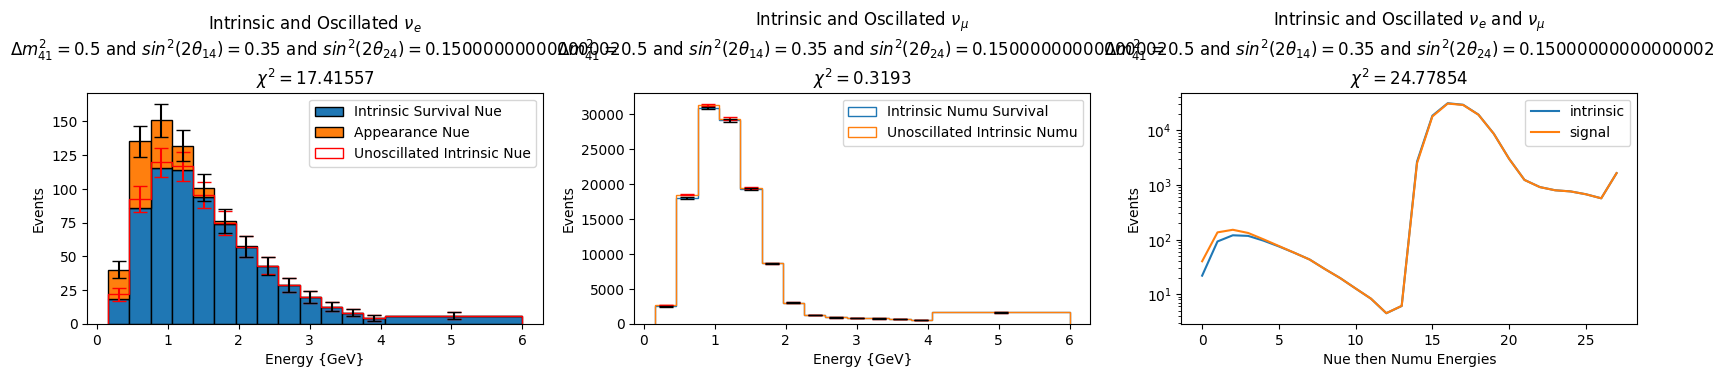

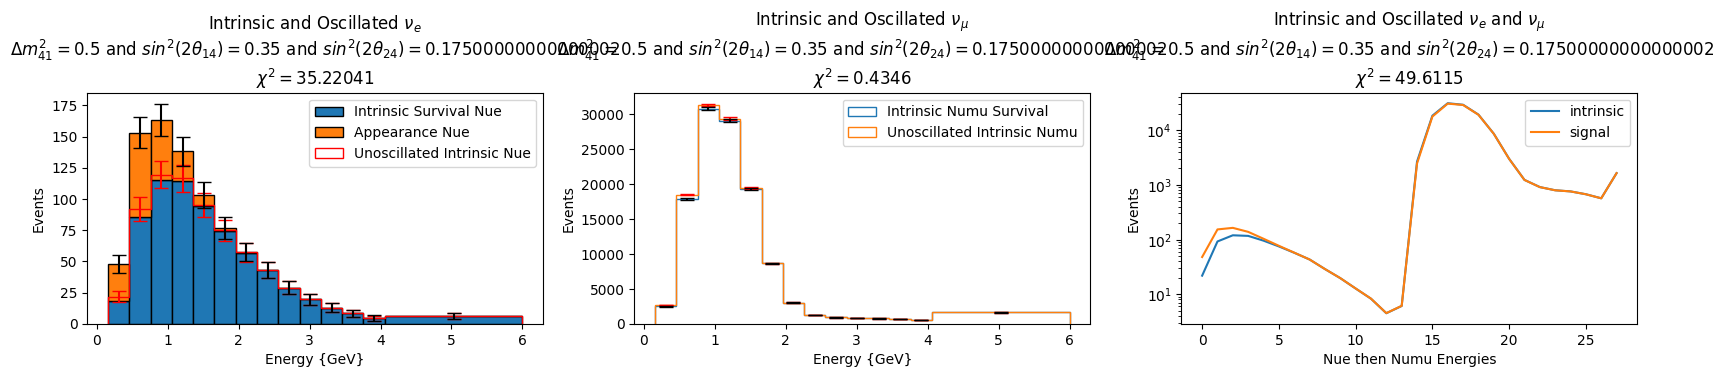

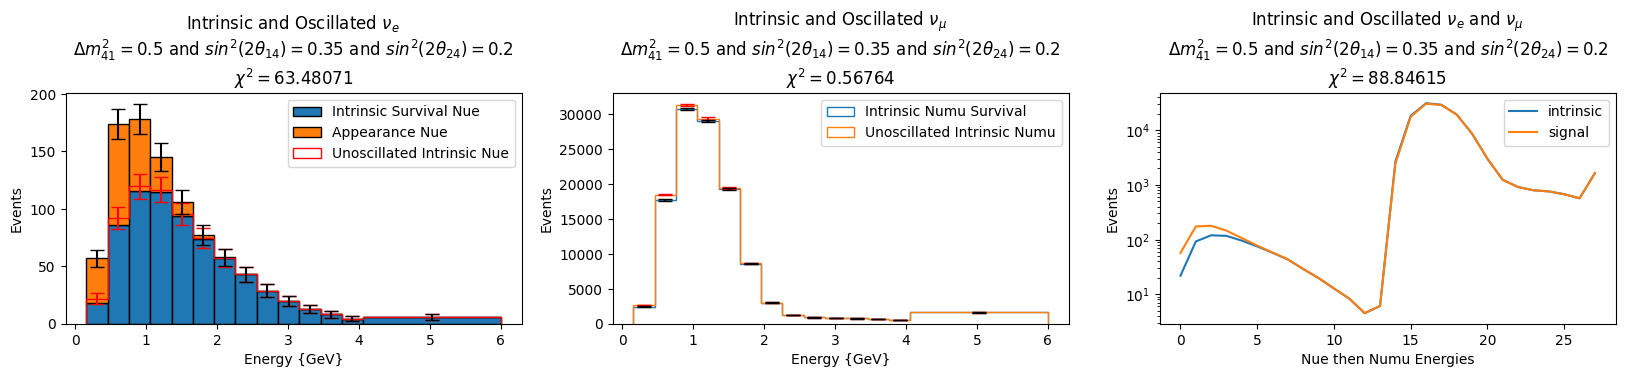

In [11]:
icecube_fits = np.zeros(sin2s_14.shape[0])
prospect_fits = np.zeros(sin2s_24.shape[0])

#vary the sin2_14
for i in range(len(icecube_fits)):
    nue, numu, total = osc_chi2([4.5, sin2s_14[i], 0.1], intrin_e, osc_e, cc_mu, sin2s=True)
    icecube_fits[i] = total
    
#vary the sin2_14
for j in range(len(prospect_fits)):  
    nue,numu, total = osc_chi2([0.5, 0.35, sin2s_24[j]], intrin_e, osc_e, cc_mu, sin2s=True)
    prospect_fits[j] = total

In [17]:
sin2s_14

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

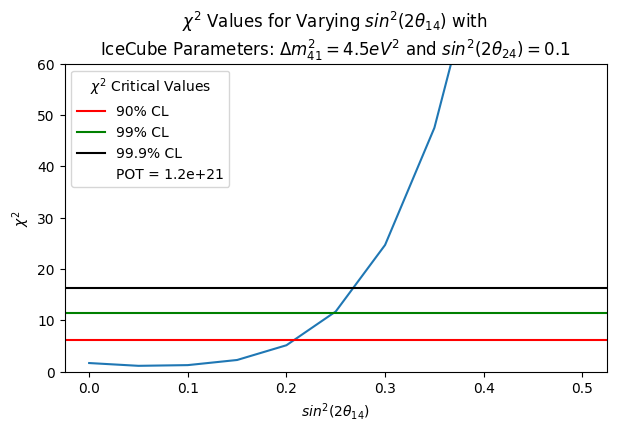

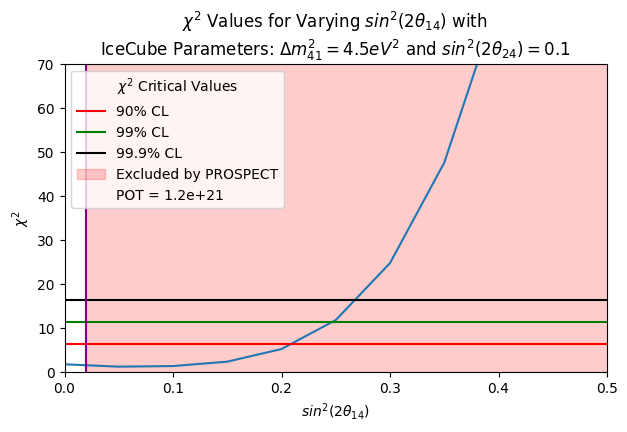

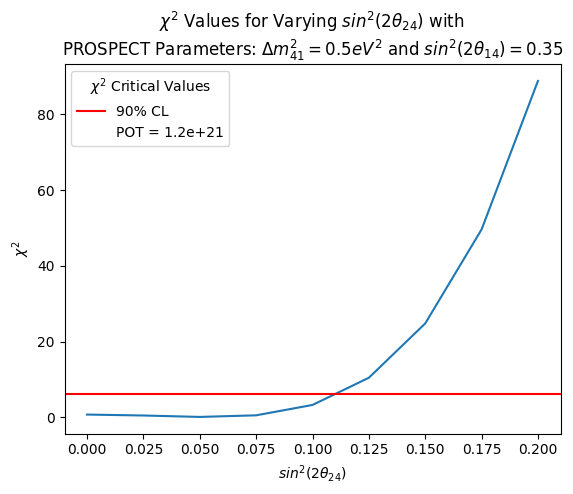

In [39]:
plt.figure(figsize=(7,4))
plt.plot(sin2s_14, icecube_fits)
plt.title("$\\chi^2$ Values for Varying $sin^2(2\\theta_{14})$ with \nIceCube Parameters: $\Delta{m}^2_{41}=4.5eV^2$" " and $sin^2(2\\theta_{24})=0.1$")
plt.xlabel("$sin^2(2\\theta_{14})$")
plt.ylabel("$\\chi^2$")
plt.ylim(0,60)
plt.axhline(6.25, label="90% CL", color="red")
plt.axhline(11.35, label="99% CL", color="green")
plt.axhline(16.27, label="99.9% CL", color="black")
#plt.scatter(0.35, icecube_fits[7], label="Using PROSPECT's $sin^2(2\\theta_{14})=0.35$", color="orange")
plt.scatter(0.1,100, color="white", label="POT = 1.2e+21")
plt.legend(title="$\\chi^2$ Critical Values")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(sin2s_14, icecube_fits)
plt.title("$\\chi^2$ Values for Varying $sin^2(2\\theta_{14})$ with \nIceCube Parameters: $\Delta{m}^2_{41}=4.5eV^2$" " and $sin^2(2\\theta_{24})=0.1$")
plt.xlabel("$sin^2(2\\theta_{14})$")
plt.ylabel("$\\chi^2$")
plt.axhline(6.25, label="90% CL", color="red")
plt.axhline(11.35, label="99% CL", color="green")
plt.axhline(16.27, label="99.9% CL", color="black")
plt.axvline(0.02, color="purple")#, label="PROSPECT Limit")
plt.fill_between(np.arange(0.02,0.6, 0.01), 70, color='red', alpha=0.2, label="Excluded by PROSPECT")
#plt.scatter(0.35, icecube_fits[7], label="Using PROSPECT's $sin^2(2\\theta_{14})=0.35$", color="orange")
plt.scatter(0.1,100, color="white", label="POT = 1.2e+21", alpha=0)
plt.legend(title="$\\chi^2$ Critical Values", loc="best")
plt.ylim(0,70)
plt.xlim(0,0.5)
plt.show()

plt.plot(sin2s_24, prospect_fits)
#plt.xscale("log")
plt.title("$\\chi^2$ Values for Varying $sin^2(2\\theta_{24})$ with \nPROSPECT Parameters: $\Delta{m}^2_{41}=0.5eV^2$" " and $sin^2(2\\theta_{14})=0.35$")
plt.xlabel("$sin^2(2\\theta_{24})$")
plt.ylabel("$\\chi^2$")
plt.axhline(6.25, label="90% CL", color="red")
#plt.axhline(11.35, label="99% CL", color="green")
#plt.axhline(16.27, label="99.9% CL", color="black")
#plt.scatter(0.1, prospect_fits[4], label="Using IceCube's $sin^2(2\\theta_{24})=0.1$", color="orange")
plt.scatter(0.05,40, color="white", label="POT = 1.2e+21")
plt.legend(title="$\\chi^2$ Critical Values")
plt.show()

$sin^2(2\theta_{14}) > 0.02$


$\Delta{m_{41}^2} = 4.5eV$

In [13]:
2*(10**-2)

0.02